# Predicting Blood Donors - Driven Data Competition
This dataset is part of a competition on drivendata.org and the goal is to predict who will donate to a blood drive 

# Data Import and Exploration

In [61]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing 
from sklearn.metrics import log_loss
from math import log

%matplotlib inline

In [38]:
# read in the training data set
train = pd.read_csv("training_data.csv", index_col=0)
# read in test data set
test = pd.read_csv("test_data.csv", index_col=0)

In [39]:
print("Shape of training data: ", train.shape, "\n")
print("Top 5 rows of training data: \n", train.head(5), "\n")
print("Data types of training data: \n", train.dtypes, "\n")
print("Summary of training data: \n", train.describe(), "\n")
print("Number of missing values in training data: \n", train.isna().sum(), "\n")

Shape of training data:  (576, 5) 

Top 5 rows of training data: 
      Months since Last Donation  Number of Donations  \
619                           2                   50   
664                           0                   13   
441                           1                   16   
160                           2                   20   
358                           1                   24   

     Total Volume Donated (c.c.)  Months since First Donation  \
619                        12500                           98   
664                         3250                           28   
441                         4000                           35   
160                         5000                           45   
358                         6000                           77   

     Made Donation in March 2007  
619                            1  
664                            1  
441                            1  
160                            1  
358                           

In [40]:
# The training data set contains the target label for each row (whether a person donated) so we need
# to remove that and store it before using the data to make predictions
y = train["Made Donation in March 2007"]

# take a look at labels to make sure the correct information is present
print(y[0:10])

# remove the columns 
train = train.drop(columns = ["Made Donation in March 2007"])

# check dataframe to confirm dropped columns
train.head()

619    1
664    1
441    1
160    1
358    0
335    0
47     1
164    0
736    1
436    0
Name: Made Donation in March 2007, dtype: int64


,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation
619,2,50,12500,98
664,0,13,3250,28
441,1,16,4000,35
160,2,20,5000,45
358,1,24,6000,77


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015DF53425F8>,
      dtype=object)

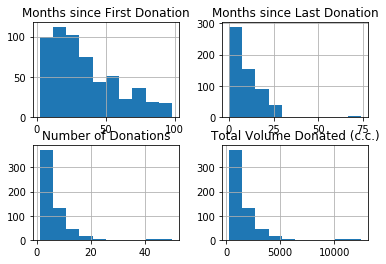

In [41]:
# check histograms of columns
train.hist()

In [42]:
# check number of outliers
# months since last donation appears to have most data below 30 months. check to see how many rows are greater than 30
print("Outliers in Months since last donation: ", (train["Months since Last Donation"] > 30).sum())
# number of donations outliers occur somewhere between 20 and 40, we will say roughly 30 again
print("Outliers in number of donations: ", (train["Number of Donations"] > 30).sum())
# total volume donated has a outlier cutoff around 6000 or so
print("Outliers in volume donated: ", (train["Total Volume Donated (c.c.)"] > 6000).sum())

Outliers in Months since last donation:  4
Outliers in number of donations:  6
Outliers in volume donated:  6


***There appear to be a small number of outliers in each column. Roughly 1% or so (6 out of 576) entries of the each column. If I make the assumption that each outlier is an independent row (it is possible that some rows are outliers in mulitple columns) then at most around 3% of the data (16/576 rows) would be deleted if I chose to remove outliers. Some classification algorithms such as random forest are extremely robust to outliers so it would not affect them much if I left these rows in the data. However I am going to make the decision to remove the outliers.***

(566, 4)
     Months since Last Donation  Number of Donations  \
664                           0                   13   
441                           1                   16   
160                           2                   20   
358                           1                   24   
335                           4                    4   

     Total Volume Donated (c.c.)  Months since First Donation  
664                         3250                           28  
441                         4000                           35  
160                         5000                           45  
358                         6000                           77  
335                         1000                            4  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015DF5973A90>,
      dtype=object)

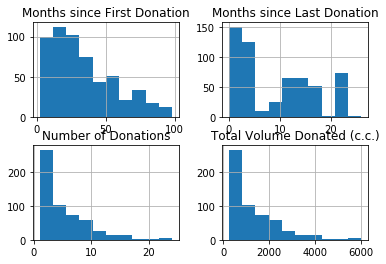

In [133]:
# combined logic checks for outliers from above. create a logical vector for subsetting data frame
outliers = (train["Months since Last Donation"] > 30) \
| (train["Number of Donations"] > 30) \
| (train["Total Volume Donated (c.c.)"] > 6000)

# subset training data
train_no_outliers = train[~outliers]

# check training data without outliers
print(train_no_outliers.shape)
print(train_no_outliers.head(5))
train_no_outliers.hist()

In [134]:
# need to make sure to create labels without outliers as well
y_no_outliers = y[~outliers]

#check length of labels
len(y_no_outliers)

566

***Even after outliers have been removed there appears to be some skew in the data of number of donations as well as total volume donated. Another point to take in to consideration is the scale of the values from the different columns. Months since last donation ranges from 0 to 30 while the total volume donated ranges from 0 to 6000. This will cause some algorithms to heavily weight the influence of total volume due to its large values. Therefore scaling or normalization will be a necessary step for those algorithms.***

     Months since Last Donation  Number of Donations  \
664                   -1.292291             1.846876   
441                   -1.151060             2.545006   
160                   -1.009828             3.475845   
358                   -1.151060             4.406683   
335                   -0.727366            -0.247511   

     Total Volume Donated (c.c.)  Months since First Donation  
664                     1.846876                    -0.221954  
441                     2.545006                     0.077155  
160                     3.475845                     0.504454  
358                     4.406683                     1.871808  
335                    -0.247511                    -1.247469  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015DF54FD278>,
      dtype=object)

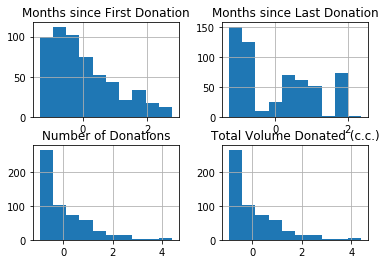

In [45]:
# standardizing data set
std_scale = preprocessing.StandardScaler().fit(train_no_outliers)
train_std = std_scale.transform(train_no_outliers)
# create data frame from scaled data
train_std = pd.DataFrame(train_std, index=train_no_outliers.index, columns=train_no_outliers.columns)
# check top rows and histograms of scaled data
print(train_std.head())
train_std.hist()

*** Since the test data provided for this competition does not have labels, I have chosen to split my training data into train/test sets for model evaluation***

In [46]:
# create train/test split for model evaluation
X_train, X_test, y_train, y_test = train_test_split(train_std, y_no_outliers, test_size = .3, random_state = 1337)
# quick data check
print(X_train.shape)
print(len(y_train))
X_train.head()

(396, 4)
396


,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation
295,1.956028,-0.247511,-0.247511,2.299106
689,-0.727366,-0.945640,-0.945640,-1.247469
420,1.956028,1.614167,1.614167,2.256376
468,1.673565,-0.712931,-0.712931,-0.435603
593,0.967409,-0.014801,-0.014801,1.145401


In [95]:
# This competition uses log loss as its evaluation metric, therefore I will create a function to calculate log loss
def log_loss_custom(predictions, actuals):
    #convert to numpy arrays for element wise multiplication without list comprehension
    predictions, actuals = np.array(predictions), np.array(actuals)
    n = len(predictions)
    # equation for log loss, adding and subtracting small values from predictions to avoid log(0) errors
    return  - sum( (actuals * [log(i) for i in predictions+1e-15]) \
                  + ((1-actuals)*[log(1-i) for i in predictions-1e-15] )) / n

In [97]:
# start with a Random Forest due to ease of use 
rf_model = RandomForestClassifier(random_state=42)
rf_model = rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict_proba(X_test)[:,1]
#print(log_loss_custom(rf_predictions, y_test))
log_loss(y_test,rf_predictions)

2.2360029694756967

In [98]:
# Naive Bayes again due to ease of use
nb_model = GaussianNB()
nb_model = nb_model.fit(X_train, y_train)
nb_predictions = nb_model.predict_proba(X_test)[:,1]
#log_loss_custom(nb_predictions, y_test)
log_loss(y_test,nb_predictions)

0.5265653129406301

In [110]:
# Logistic regression
logreg_model = LogisticRegression(solver="lbfgs",C=0.5, max_iter=500)
logreg_model = logreg_model.fit(X_train, y_train)
logreg_predictions = logreg_model.predict_proba(X_test)[:,1]
#log_loss_custom(logreg_predictions, y_test)
log_loss(y_test,logreg_predictions)

0.4656332468184813

In [124]:
# mutlilayer perceptron
mlp_model = MLPClassifier(solver="lbfgs", alpha=1e-8,hidden_layer_sizes=(6,2))
mlp_model = mlp_model.fit(X_train, y_train)
mlp_predictions = mlp_model.predict_proba(X_test)[:,1]
#log_loss_custom(mlp_predictions, y_test)
log_loss(y_test,mlp_predictions)

0.46585019171534925

## Transformations on skewed variables and second attempt at modeling

Before transformations: 
 [[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015DF7540A90>
After transformations: 
 [[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015DF6CF0940>


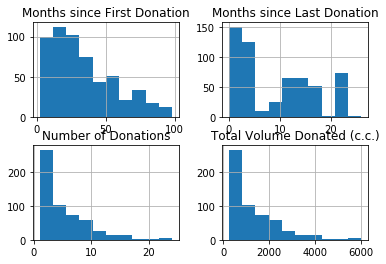

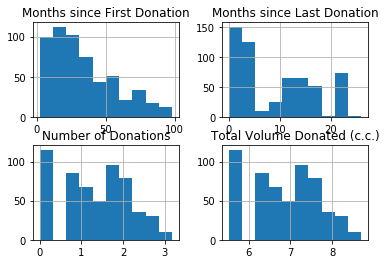

In [142]:
# transforming skewed data columns
print("Before transformations: \n", train_no_outliers.hist())
# create a copy of data frame withot outliers
train_fix_skew = train_no_outliers.copy()
# apply transformation to new data. use original data frame so not constantly applying transform
# every time this cell is run
train_fix_skew.loc[:,"Number of Donations"] = train_no_outliers.loc[:,"Number of Donations"].apply(log)
train_fix_skew.loc[:,"Total Volume Donated (c.c.)"] = train_no_outliers.loc[:,"Total Volume Donated (c.c.)"].apply(log)
print("After transformations: \n", train_fix_skew.hist())

     Months since Last Donation  Number of Donations  \
664                   -1.292291             1.498375   
441                   -1.151060             1.739180   
160                   -1.009828             1.997964   
358                   -1.151060             2.209407   
335                   -0.727366             0.131462   

     Total Volume Donated (c.c.)  Months since First Donation  
664                     1.498375                    -0.221954  
441                     1.739180                     0.077155  
160                     1.997964                     0.504454  
358                     2.209407                     1.871808  
335                     0.131462                    -1.247469  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015DF6D4A7B8>,
      dtype=object)

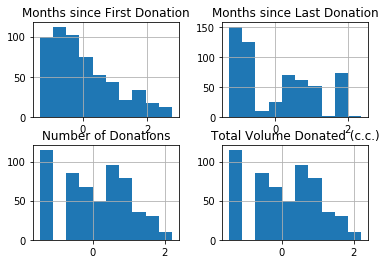

In [143]:
# standardizing data set
std_scale = preprocessing.StandardScaler().fit(train_fix_skew)
train_std = std_scale.transform(train_fix_skew)
# create data frame from scaled data
train_std = pd.DataFrame(train_std, index=train_fix_skew.index, columns=train_fix_skew.columns)
# check top rows and histograms of scaled data
print(train_std.head())
train_std.hist()

In [144]:
# create train/test split for model evaluation
X_train, X_test, y_train, y_test = train_test_split(train_std, y_no_outliers, test_size = .3, random_state = 1337)
# quick data check
print(X_train.shape)
print(len(y_train))
X_train.head()

(396, 4)
396


,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation
295,1.956028,0.131462,0.131462,2.299106
689,-0.727366,-1.476255,-1.476255,-1.247469
420,1.956028,1.405548,1.405548,2.256376
468,1.673565,-0.672396,-0.672396,-0.435603
593,0.967409,0.390247,0.390247,1.145401


In [145]:
# start with a Random Forest due to ease of use 
rf_model = RandomForestClassifier(random_state=42)
rf_model = rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict_proba(X_test)[:,1]
#print(log_loss_custom(rf_predictions, y_test))
log_loss(y_test,rf_predictions)

2.238910485177859

In [146]:
# Naive Bayes again due to ease of use
nb_model = GaussianNB()
nb_model = nb_model.fit(X_train, y_train)
nb_predictions = nb_model.predict_proba(X_test)[:,1]
#log_loss_custom(nb_predictions, y_test)
log_loss(y_test,nb_predictions)

0.4903076809826416

In [147]:
# Logistic regression
logreg_model = LogisticRegression(solver="lbfgs",C=0.5, max_iter=500)
logreg_model = logreg_model.fit(X_train, y_train)
logreg_predictions = logreg_model.predict_proba(X_test)[:,1]
#log_loss_custom(logreg_predictions, y_test)
log_loss(y_test,logreg_predictions)

0.45233365513946494

In [148]:
# mutlilayer perceptron
mlp_model = MLPClassifier(solver="lbfgs", alpha=1e-8,hidden_layer_sizes=(6,2))
mlp_model = mlp_model.fit(X_train, y_train)
mlp_predictions = mlp_model.predict_proba(X_test)[:,1]
#log_loss_custom(mlp_predictions, y_test)
log_loss(y_test,mlp_predictions)

0.47466130259151

## Making predictions on test data and exporting for submission

In [101]:
# check test data
print("Shape of testing data: ", test.shape, "\n")
print("Top 5 rows of testing data: \n", test.head(5), "\n")
print("Data types of testing data: \n", test.dtypes, "\n")
print("Summary of testing data: \n", test.describe(), "\n")
print("Number of missing values in testing data: \n", test.isna().sum(), "\n")

Shape of testing data:  (200, 4) 

Top 5 rows of testing data: 
      Months since Last Donation  Number of Donations  \
659                           2                   12   
276                          21                    7   
263                           4                    1   
303                          11                   11   
83                            4                   12   

     Total Volume Donated (c.c.)  Months since First Donation  
659                         3000                           52  
276                         1750                           38  
263                          250                            4  
303                         2750                           38  
83                          3000                           34   

Data types of testing data: 
 Months since Last Donation     int64
Number of Donations            int64
Total Volume Donated (c.c.)    int64
Months since First Donation    int64
dtype: object 

Summary of testing

     Months since Last Donation  Number of Donations  \
659                   -0.986184             0.992653   
276                    1.513816             0.174308   
263                   -0.723026            -0.807707   
303                    0.198026             0.828984   
83                    -0.723026             0.992653   

     Total Volume Donated (c.c.)  Months since First Donation  
659                     0.992653                     0.659724  
276                     0.174308                     0.100805  
263                    -0.807707                    -1.256570  
303                     0.828984                     0.100805  
83                      0.992653                    -0.058886  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015DF59EF630>,
      dtype=object)

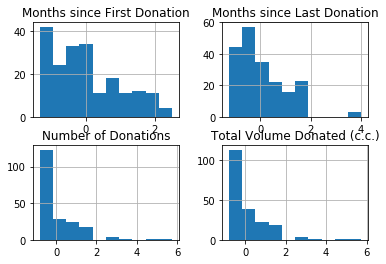

In [102]:
# standardizing test data set since models were built on scaled data
std_scale = preprocessing.StandardScaler().fit(test)
test_std = std_scale.transform(test)
# create data frame from scaled data
test_std = pd.DataFrame(test_std, index=test.index, columns=test.columns)
# check top rows and histograms of scaled data
print(test_std.head())
test_std.hist()

In [103]:
# make predictions using trained Random Forest model from above
rf_predictions = rf_model.predict_proba(test)[:,1]
rf_predictions_df = pd.DataFrame(rf_predictions, index=test.index, columns=["Made Donation in March 2007"])
print(rf_predictions_df.head())
print(rf_predictions_df.describe())

     Made Donation in March 2007
659                          0.2
276                          0.4
263                          0.4
303                          0.4
83                           0.4
       Made Donation in March 2007
count                   200.000000
mean                      0.374000
std                       0.082206
min                       0.200000
25%                       0.400000
50%                       0.400000
75%                       0.400000
max                       0.500000


In [104]:
# export to csv
rf_predictions_df.to_csv("rf_donor_predictions.csv")

In [105]:
# make predictions using trained Random Forest model from above
logreg_predictions = logreg_model.predict_proba(test)[:,1]
logreg_predictions_df = pd.DataFrame(logreg_predictions, index=test.index, columns=["Made Donation in March 2007"])
print(logreg_predictions_df.head())
print(logreg_predictions_df.describe())

     Made Donation in March 2007
659                          1.0
276                          1.0
263                          1.0
303                          1.0
83                           1.0
       Made Donation in March 2007
count                        200.0
mean                           1.0
std                            0.0
min                            1.0
25%                            1.0
50%                            1.0
75%                            1.0
max                            1.0


In [106]:
# export to csv
logreg_predictions_df.to_csv("logreg_donor_predictions.csv")